In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [196]:
import glob
import warnings
import numpy as np
import pylab as plt

from scipy.ndimage import binary_dilation

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel, convolve

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ
from parabolas import loadLeicaData, fitParabola, parabola
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot, scatterPlot
from utils.utils import midPoint, getRollingStat, radialMask
from zernikies import zernikeWLS, getZernikeCoeffs
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

In [706]:
from scipy.optimize import least_squares

def parabolaFit(x, y, z, guess, bounds=None, 
                max_nfev=10000, ftol=1e-12, 
                xtol=1e-12, verbose=False, f_scale=8e-4):
    
    # Set boundaries for the fit parameters.
    if bounds is None:
        inf = np.inf
        pi2 = 2*np.pi
        cmin = -inf
        cmax = inf
        b1 = [60-5e-3, -inf, -inf, -inf, -pi2, -pi2, cmin, cmin, cmin, cmin, -2, 48]
        b2 = [60+5e-3,  inf,  inf,  inf,  pi2,  pi2, cmax, cmax, cmax, cmax,  2, 52]
        bounds = (b1, b2)
        #bounds = None
        
    # Robust fit: weights outliers outside of f_scale less
    loss = "soft_l1"
    #loss = "linear"
    #f_scale = 0.1
    x_scale = 'jac'
    x_scale = [0.1, 0.1, 0.1, 0.1, np.deg2rad(0.01), np.deg2rad(0.01), 1e-5, 1e-5, 1e-5, 1e-5, 0.1/50, 0.1/100]
    tr_solver = 'lsmr'
    
    method = fitParabola
    args = (x.flatten(), y.flatten(), z.flatten())
    
    r = least_squares(method,
                      guess,
                      args=args,
                      bounds=bounds,
                      #method='lm',
                      max_nfev=max_nfev,
                      loss=loss,
                      f_scale=f_scale,
                      ftol=ftol,
                      xtol=xtol,
                      x_scale=x_scale,
                      tr_solver=tr_solver)
    return r

def removeParabolaFit(x, y, z, fit):
    cor = np.hstack((-1*fit[1:4],fit[4:6],0))
    xgdr, ygdr, zgdr = shiftRotateXYZ(x, y, z, cor)
    zp = parabola(xgdr, ygdr, fit[0], 0, 0, 0, 0, 0, 0)
    diff = zgdr - zp
    return xgdr, ygdr, zgdr, diff

def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0, 0, 0], bounds=None, iters=2, f_scale=0.08):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        x_ = x[~mask]
        y_ = y[~mask]
        z_ = z[~mask]
        fit = parabolaFit(x_, y_, z_, guess, bounds=bounds, f_scale=f_scale)
        cor = np.hstack((-1*fit.x[1:4],fit.x[4:],0))
        xdr, ydr, zdr = shiftRotateXYZ(x, y, z, cor)
        zp = parabola(xdr, ydr, fit.x[0], 0, 0, 0, 0, 0, 0)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = res.mask
        guess = fit.x
    
    return fit, mask

def removeParabolaScan(filename, iters, n=512, guess=[60., 0, 0, -50., 0, 0], bounds=None, fit=None, f_scale=0.08):
    """
    """
    
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    xg, yg, zg = regridXYZ(x, y, z, n=n)
    xg, yg, zg = shiftRotateXYZ(xg, yg, zg, [0, 0, 0, 0, 0, np.deg2rad(178)])
    
    if fit is None:
        fit, mask = parabolaFitIterations(xg, yg, zg, guess=guess, bounds=bounds, iters=iters, f_scale=f_scale)
    else:
        mask = False
        
    cor = np.hstack((-1*fit.x[1:4],fit.x[4:6],0))
    xgdr, ygdr, zgdr = shiftRotateXYZ(xg, yg, zg, cor)
    #zgdr[mask] = np.nan
    #tht = np.arctan2(np.nanmax(zgdr)-np.nanmin(zgdr), np.nanmax(ygdr)-np.nanmin(ygdr))
    #xgr, ygr, zgr = shiftRotateXYZ(xgdr, ygdr, zgdr, [0, 0, 0, -tht, 0, 0])
    zp = parabola(xgdr, ygdr, fit.x[0], 0, 0, 0, 0, 0, 0)
    #_, _, zpr = shiftRotateXYZ(xgdr, ygdr, zp, [0, 0, 0, -tht, 0, 0])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        #diff = sigma_clip(zgdr - zp)
        diff = zgdr - zp
    return xgdr, ygdr, zgdr, diff, fit

In [673]:
n = 512
iters = 1
nZern = 36
guess = [60., 2.5, -0.7, -49., 0.2, 0., -500e-6, 0, 0, 0, -0.9, 51.2]
iz = 4
izv = -486
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [674]:
%%time
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
#refScan = "{0}/ref_average.ptx.csv".format(scanDir)
xr, yr, zr, rDiff, rFit = removeParabolaScan(refScan, iters, n=n, 
                                             guess=[60., 2.5, -0.7, -49., 0.2, 0., 0, 0, 0, 0, -0.9, 51.2])

CPU times: user 8h 57min 4s, sys: 8h 15min 23s, total: 17h 12min 28s
Wall time: 45min 9s


In [707]:
%%time
#sigScan = "{0}/2020_03_16_02:28:31.ptx.csv".format(scanDir) # C4=-518
sigScan = "{0}/2020_03_16_03:02:51.ptx.csv".format(scanDir) # C4=-486
#sigScan = "{0}/2020_03_16_06:18:53.ptx.csv".format(scanDir) # C13=-56
#sigScan = "{0}/2020_03_16_05:54:35.ptx.csv".format(scanDir) # C13=-169
#sigScan = "{0}/2020_03_16_04:41:09.ptx.csv".format(scanDir) # C7=-144
#sigScan = "{0}/2020_03_16_05:30:05.ptx.csv".format(scanDir) # C13=-534
#sigScan = "{0}/2020_03_16_04:16:39.ptx.csv".format(scanDir) # C7=-545
#sigScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir) 
#sigScan = "{0}/2020_03_16_09:09:14.ptx.csv".format(scanDir) # C13=-534
#sigScan = "{0}/462_2019-10-11_05:32:34.ptx.csv".format(scanDir)
#sigScan = "{0}/444_2019-10-11_03:34:50.ptx.csv".format(scanDir)
#sigScan = "{0}/450_2019-10-11_04:13:53.ptx.csv".format(scanDir) # C15=1080
#sigScan = "{0}/452_2019-10-11_04:26:55.ptx.csv".format(scanDir) # C15=596
#sigScan = "{0}/456_2019-10-11_04:53:08.ptx.csv".format(scanDir) # C7=-1080
#sigScan = "{0}/381_2019-10-10_20:02:30.ptx.csv".format(scanDir) # C13=-596
#sigScan = "{0}/365_2019-10-10_18:19:37.ptx.csv".format(scanDir) # C13=-225
#sigScan = "{0}/474_2019-10-11_06:50:39.ptx.csv".format(scanDir)
#sigScan = "{0}/448_2019-10-11_04:00:54.ptx.csv".format(scanDir)
#sigScan = "{0}/410_2019-10-10_23:50:15.ptx.csv".format(scanDir)
#sigScan = "{0}/406_2019-10-10_23:24:08.ptx.csv".format(scanDir)
#sigScan = "{0}/365_2019-10-10_18:19:37.ptx.csv".format(scanDir)
#sigScan = "{0}/367_2019-10-10_18:32:24.ptx.csv".format(scanDir)
#sigScan = "{0}/420_2019-10-11_00:55:24.ptx.csv".format(scanDir)
#sigScan = "{0}/359_2019-10-10_17:41:11.ptx.csv".format(scanDir) # C7=-225
#sigScan = "{0}/354_2019-10-10_17:09:14.ptx.csv".format(scanDir) # C7=0
#sigScan = "{0}/355_2019-10-10_17:15:30.ptx.csv".format(scanDir) # C7=-1080
xs, ys, zs, sDiff, sFit = removeParabolaScan(sigScan, iters, n=n//2, 
                                             guess=[60., 2.5, -0.7, -49., 0.2, 0., 
                                                    -5e-4, -5e-4, -5e-4, -5e-4, -0.9, 51.2])

CPU times: user 2h 33min 13s, sys: 3h 8min 59s, total: 5h 42min 12s
Wall time: 21min 26s


In [708]:
sFit.x, rFit.x, sFit.x[0]+5e-3

(array([ 5.99950001e+01,  2.45681426e+00, -8.87825352e-01, -4.92923705e+01,
         2.19139719e-01, -4.99351066e-03, -4.99894515e-04, -4.99972931e-04,
        -5.00006357e-04, -4.99951406e-04, -9.00092719e-01,  5.11999457e+01]),
 array([ 5.99950001e+01,  2.45175355e+00, -9.05552072e-01, -4.92936976e+01,
         2.19278540e-01, -5.07336136e-03,  1.05604449e-09,  2.40762598e-10,
        -6.97765678e-11,  4.57176125e-10, -8.99999991e-01,  5.12000000e+01]),
 60.00000007051365)

In [710]:
sFit.status

2

<IPython.core.display.Javascript object>


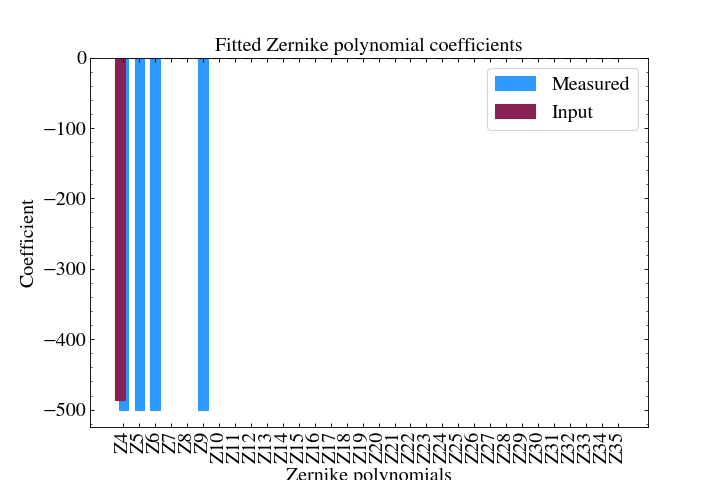

In [709]:
zc = np.zeros(nZern)
zc[4] = sFit.x[6]
zc[5] = sFit.x[7]
zc[6] = sFit.x[8]
zc[9] = sFit.x[9]
expected = np.zeros(nZern)
expected[iz] = izv
barChartPlot(np.arange(4,36), zc[4:36]*1e6, expected=expected[4:36])

<IPython.core.display.Javascript object>


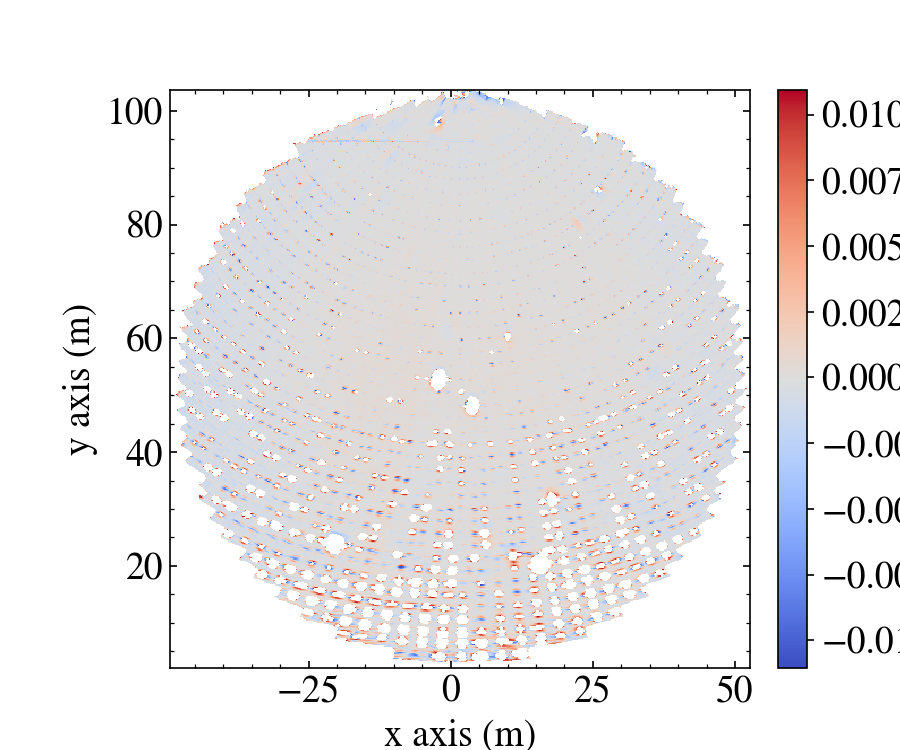

<IPython.core.display.Javascript object>


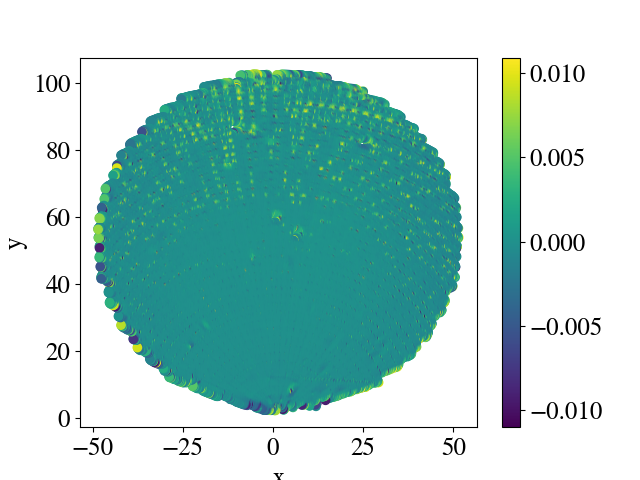

0.0014265377693541078


In [687]:
diff = sigma_clip(sDiff - rDiff, 4)
mask = binary_dilation(diff.mask, iterations=1)
diff = np.ma.masked_where(mask, diff)

xDiff = xr
yDiff = yr

vmin = np.nanmin(diff)
vmax = np.nanmax(diff)
surfacePlot(xr, yr, diff.T, vMin=vmin, vMax=vmax, midPoint=(vmax+vmin)/2.)
scatterPlot(xr, yr, diff)
print(diff.std())

<IPython.core.display.Javascript object>


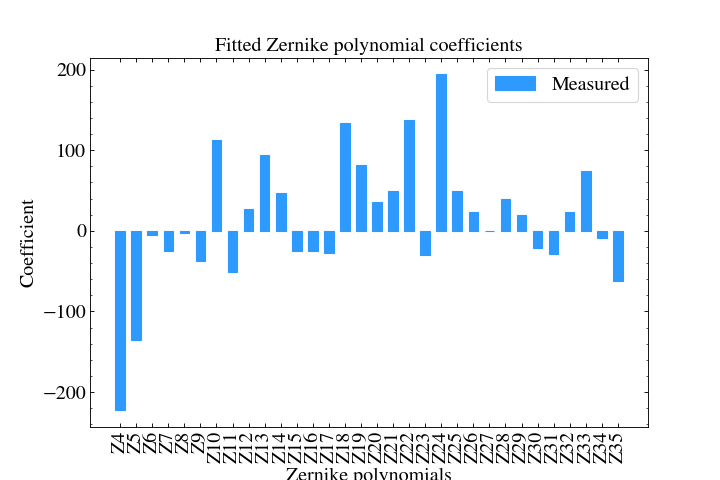

-222.69549440458408 -299.19656047366345


In [688]:
fl_fs = getZernikeCoeffs(diff.filled(0)[::-1].T, nZern, norm='active-surface')
barChartPlot(np.arange(4,36), fl_fs[4:36]*1e6)
fl_ls = zernikeWLS(xDiff[:,::-1], yDiff[::-1,:], diff[::-1,::-1], nZern, weighted=False)
print(fl_fs[iz]*1e6, fl_ls[iz]*1e6)

In [671]:
previous: 305

In [711]:
100/1e-6

100000000.0